In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download -d msambare/fer2013

 63% 38.0M/60.3M [00:00<00:00, 125MB/s]
100% 60.3M/60.3M [00:00<00:00, 158MB/s]


In [3]:
! unzip "/content/fer2013.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [4]:
import os
import shutil
shutil.rmtree('/content/train/disgust')
shutil.rmtree('/content/test/disgust')

In [5]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

In [6]:
num_classes = 6
img_rows,img_cols = 48,48
batch_size = 32

train_data_dir = '/content/train'
validation_data_dir = '/content/test'

In [7]:
train_datagen = ImageDataGenerator(
					rescale=1./255,
					rotation_range=30,
					shear_range=0.2,
					zoom_range=0.2,
					width_shift_range=0.3,
					height_shift_range=0.3,
					horizontal_flip=True,
					fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(
					train_data_dir,
					color_mode='grayscale',
					target_size=(img_rows,img_cols),
					batch_size=batch_size,
					class_mode='categorical',
					shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
							validation_data_dir,
							color_mode='grayscale',
							target_size=(img_rows,img_cols),
							batch_size=batch_size,
							class_mode='categorical',
							shuffle=True)

Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


In [9]:
model = Sequential()

# Block-1

model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(img_rows,img_cols,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(img_rows,img_cols,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

# Block-2 

model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

# Block-3

model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block-4 

model.add(Conv2D(512,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(512,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

# Block-5

model.add(Flatten())
model.add(Dense(512,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

# Block-6

model.add(Dense(128,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

# Block-7

model.add(Dense(num_classes,kernel_initializer='he_normal'))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                        

In [10]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=.0001), metrics=['accuracy'])

nb_train_samples = 28273 
nb_validation_samples = 7067
epochs=100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
history=model.fit_generator(
                train_generator,
                steps_per_epoch=nb_train_samples//batch_size,
                epochs=epochs,
                validation_data=validation_generator,
                validation_steps=nb_validation_samples//batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
883/883 [==============================] - 90s 87ms/step - loss: 1.9324 - accuracy: 0.2159 - val_loss: 1.7249 - val_accuracy: 0.2727
Epoch 2/100
883/883 [==============================] - 76s 86ms/step - loss: 1.8003 - accuracy: 0.2492 - val_loss: 1.6740 - val_accuracy: 0.3146
Epoch 3/100
883/883 [==============================] - 76s 86ms/step - loss: 1.7600 - accuracy: 0.2715 - val_loss: 1.6114 - val_accuracy: 0.3376
Epoch 4/100
883/883 [==============================] - 76s 86ms/step - loss: 1.7104 - accuracy: 0.2989 - val_loss: 1.4950 - val_accuracy: 0.4084
Epoch 5/100
883/883 [==============================] - 75s 85ms/step - loss: 1.6347 - accuracy: 0.3408 - val_loss: 1.4398 - val_accuracy: 0.4499
Epoch 6/100
883/883 [==============================] - 76s 86ms/step - loss: 1.5420 - accuracy: 0.3820 - val_loss: 1.3625 - val_accuracy: 0.4604
Epoch 7/100
883/883 [==============================] - 75s 85ms/step - loss: 1.4684 - accuracy: 0.4160 - val_loss: 1.3145 - val_ac

In [12]:
model.save("lowLearningRate0001.h5")

In [13]:
import matplotlib.pyplot as plt

def plot_graphs(history):
    """
    Plot accuracy and loss graph
    Arguments:
        History: model history
    """

    # ACCURACY
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend(['accuracy', 'val_accuracy'])

    # Show figure
    plt.show()

    # LOSS
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend(['loss', 'val_loss'])

    # Show figure
    plt.show()

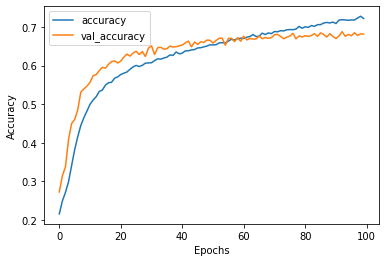

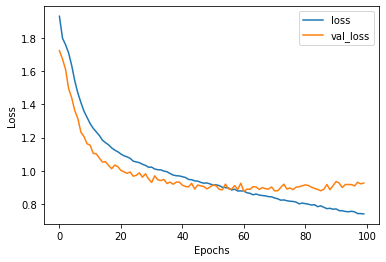

In [14]:
plot_graphs(history)